<a id ='top'></a>

In [2]:
''' all necessary imports '''
from mesa.time import RandomActivation, SimultaneousActivation
from mesa.datacollection import DataCollector
from mesa import Agent, Model
from mesa.batchrunner import BatchRunner

import networkx as nx
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

<a id="top"> </id>
# Game Theory ABM


## Index:
 

 * Functions to plot results
  - [Functions](#results_functions)


* Replicating Abari and White model:
 - [Model Class](#Model)
 - [Agent Class](#Agent)
 - [Experiment 1](#experiment_1)
 - [Experiment 2](#experiment_2)
 - [Experiment 3](#experiment_3)
 - [Experiment 4](#experiment_4)
 
note: internal links may not work in Jupyter Lab


### Terminology:
Interactions:
- DI
>
>  Direct Interaction (each agents interact with his neighbourhood, one agent at a time. Each one decides whether or not to cooperate)
>
- WI 
>
> Witness Interaction (each agents asks his neighbourhood an opinion on an untrustworthy agents. Each neighbour decides whether or not to cooperate)
>

Agents:
- NA
>
> Naive agent, will always cooperate in DI, return a positive opinion of other agents in WI (thus sometimes cooperating other times not), will never drop anyone
>
- MA
>
> Malicious agent, will always defect in DI, return the opposite of his opinion in WI (always defecting also here, trying to fool), will never drop anyone
>
- TA
>
> Trust-aware agent, generally speaking he will always cooperate with agents who cooperate in DI, and will always cooperate in WI, returning his opinion. He will drop agents untrustworthy in DI
>
- TAplus
>
> As TA, but will drop also agents untrustworthy in WI
>

# Replicating Abari and White model

### Most relevant agent Parameters and Variables:
- d_alpha
>
>  Used for updating trust value in CDI scenarios (cooperation in Direct Interactions)
>
>  It must be > 0, the higher the easier an agent gains trust 

- w_alpha
>
>  Same as d_alpha, but in Witness Interactions (WI)
>

- d_beta
>
>  Used for updating trust value in DDI scenarios (defection in Direct Interactions)
>
> It must be < 0, the higher, the easier an agent loses trust


- w_beta
>
>  Same as d_beta, but in Witness Interactions (WI)
>

- _omega_
>
>  Threshold value (between -1 and 1): if the DI of an agents is above omega, than that agent is deemed trustworthy 
>


- _OMEGA_
>
>  Threshold value (between -1 and 1): if the DI of an agents falls below OMEGA, than that agent is deemed untrustworthy 
>

- _direct_trust_dict_ 
> 
> Dictionary containing the latest trust value of the agent in exam (agent i) towards agent j, in terms of direct interaction
>
> { 'instance' : latest_trust_value }; note: every agent has his own such dictionary
> 

- _witness_trust_dict_ 
> 
> Dictionary containing the latest trust value of the agent in exam (agent i) towards agent j, in terms of witness interaction
>
> { 'instance' : latest_trust_value }; note: every agent has his own such dictionary
> 

- _neighbourhood_ 
> 
> List containing the **instance** of the agents in the neighbourhood

- _neigh_evo_
>
> Will allow to obtain the ids of neighbouring agents at a chosen step and for a chosen agent. Needed because Data Collector isn't well behaved with lists


- _already_interacted_list_ 
> 
> List containing the **instance** of the agents already interacted with, in a specific time-step (emptied when the agents concludes his interactions for that time-step)

- _blacklist_ 
> 
> List containing the **instance** of the agents untrustworthy based on DI


<a id ="Model"> </a>
# Model Class

**note**: we let omegas assume, by default (keywork argument in the class), values distributed according to a normal with mean 0.3 (or -0.3 for OMEGA) and variance 0.5 

In [2]:
class GameModel(Model):
    """A model with: 
    N = number of agents
    TAplusp,TAp,MAp,NAp: percentages of respective agent types
    other vars are described above in the markdown cell
    """
    def __init__(self, N, TAplusp, TAp, MAp, NAp, d_alpha, w_alpha, d_beta, w_beta, DT, OMEGA = -0.5, omega = 0.5, heter_omegas = True, omegas_var = 0.3,omegas_mean = 0.5):
        
        self.num_agents = N
        self.schedule = RandomActivation(self)    #RandomActivation  # SimultaneousActivation 
        self.running = True    
        
# Add Data Collector
        self.datacollector = DataCollector(
            model_reporters={"Avg_Neigh": avg_num_neighbours,
                             "AVG_TA_neigh":avg_num_neighbours_TA,
                             "avg_TA_wealth": avg_TA_wealth,
                             "avg_MA_wealth": avg_MA_wealth,
                             "avg_NA_wealth":avg_NA_wealth,
                            "avg_MA_in_TA":avg_MA_in_TA},

            agent_reporters={"Wealth": "wealth",
                             "Type":"type",
                             "MA_encoutered":"ma_encountered"})  #,"DIT_evo":"DIT_evo"

        # Get Agent quantities
        num_TAplus = int(TAplusp*self.num_agents)
        num_TA     = int(TAp*self.num_agents)
        num_MA     = int(MAp*self.num_agents)
        num_NA     = int(NAp*self.num_agents) 
        
        # Define agents characteristics
                        # type, ST, didr, answer_policy, disconnection_policy
        TAplus_char = ['TAplus', 5, "TTFT", "Ho", "St"] 
        TA_char     = ['TA', 5, "TTFT", "Ho", "Mo"]
        MA_char     = ['MA', 100, 'AD', "Li", "Le"]
        NA_char     = ['NA', 15, 'AC', "Si", "Le"]
        
        # Create Iterable of various Agents with Characteristics
        agents_chars = [TAplus_char]*num_TAplus+[TA_char]*num_TA+[MA_char]*num_MA+[NA_char]*num_NA #need them all in one line
        
        # Create agents
        for i, ch in enumerate(agents_chars):
            agent = GameAgent(unique_id = i,
                          model= self,
                          d_alpha = d_alpha,
                          w_alpha = w_alpha,
                          d_beta = d_beta, 
                          w_beta = w_beta,
                          omega = omega,
                          OMEGA = OMEGA,
                          agent_type = ch[0],
                          ST_val = ch[1],
                          didr = ch[2],
                          answering_policy_type = ch[3],
                          disc_policy = ch[4],
                          DT = DT,
                          omegas_var = omegas_var,
                          omegas_mean = omegas_mean,
                          heter_omegas = heter_omegas
                             )
            self.schedule.add(agent)
        
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        #print("\n end of step")       
        
''' Data collector functions at Model level'''

def avg_MA_in_TA(model):
    '''Get the avg number of MA connected to TA'''
    neigh_list    = [agent.neighbourhood for agent in model.schedule.agents if agent.type == "TA"]
    #print("neigh list = ", neigh_list)
    MA_in_TA_list = [agent for neigh in neigh_list for agent in neigh if agent.type == "MA"]
    return len(MA_in_TA_list)/max(1,len(neigh_list))  # num MA in neighs / num TA

def avg_num_neighbours_TA(model):
    '''Get the avg number of neighbours of TA'''
    lista = [len(agent.neighbourhood) for agent in model.schedule.agents if agent.type == "TA"]
    return sum(lista)/max(1,len(lista)) 

def avg_num_neighbours(model):
    '''Get the avg number of neighbours'''
    lista = [len(agent.neighbourhood) for agent in model.schedule.agents]
    return sum(lista)/max(1,len(lista))

def avg_TA_wealth(model):
    '''Get the avg TA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type == "TA"]
    #print("wealth incr :", [(agent.wealth - agent.prev_wealth) for agent in model.schedule.agents if agent.type == "TA"])
    #print(sum(lista))
    return sum(lista)/max(1,len(lista))

def avg_MA_wealth(model):
    '''Get the avg MA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type  == "MA"]
    return sum(lista)/max(1,len(lista))

def avg_NA_wealth(model):
    '''Get the avg NA wealth increase at each step'''
    lista = [(agent.wealth - agent.prev_wealth)/max(1,len(agent.neighbourhood)) for agent in model.schedule.agents if agent.type  == "NA"]
    return sum(lista)/max(1,len(lista))

<a id ="Agent"> </a>
# Agent Class

- [Back on top](#top)

In [3]:
class GameAgent(Agent):
    
    def __init__(self, 
                 unique_id,
                 model, 
                 d_alpha = 0.05, 
                 w_alpha = 0.05,
                 d_beta = -0.3, 
                 w_beta = -0.3,
                 omega = 0.9,
                 OMEGA = -0.9,
                 agent_type = "TA",
                 ST_val = 5,
                 didr = "TTFT",
                 answering_policy_type = "Ho",
                 disc_policy = "Mo",
                 DT = 0.25,
                 omegas_mean = 0.3,
                 omegas_var = 0.5,
                 heter_omegas = True
                ):
        
        super().__init__(unique_id, model)
        self.neighbourhood           = set()
        self.blacklist               = []
        self.connection_list         = []
        self.already_interacted_list = []
        self.wealth_list             = []
        self.visited                 = {self} #set which contains self instance, so an agent doesn't append itself to neighbour list
        self.last_interaction        = {}
        self.others_trustworthyness  = {}  
        self.direct_trust_dict       = {}   
        self.witness_trust_dict      = {} 
        self.neigh_evo               = {}
        #self.DIT_evo                 = {}
        
        self.d_alpha = d_alpha   # needs to be > 0 
        self.d_beta  = d_beta    # needs to be < 0 
        self.w_alpha = w_alpha   # needs to be > 0 
        self.w_beta  = w_beta    # needs to be < 0 
        
        if heter_omegas == True: # introduce heterogeneity among agents
            # Initialize omegas just to enter the while loop
            self.omega = 0
            self.OMEGA = 1
            while self.omega < self.OMEGA or self.OMEGA <= -1 or self.omega >= 1:
                # omegas according to a normal distribution
                self.omega = np.random.normal(omegas_mean, omegas_var, 1)
                self.OMEGA = np.random.normal(-omegas_mean, omegas_var, 1)   
            
        else:
            self.omega   = omega
            self.OMEGA   = OMEGA  
        
        self.ST             = ST_val    # three values:  Conservative (C) = 5; Naive (N) = 15, Greedy (G) = 100
        self.prev_wealth    = 0
        self.wealth         = 0
        self.avg_utility    = 0
        self.count          = 0
        self.ma_encountered = 0
        
        self.type                  = agent_type
        self.didr                  = didr        # didr= DI decision-rule; "AC", "AD", TTFT"
        self.answering_policy_type = answering_policy_type  # Ho, Li, Si
        self.disc_policy           = disc_policy # Le, Mo, St
        self.DT                    = DT   # Discrimination Threshold, set to 0.25 in the paper
        
        self.all_time_blacklist = set()
        
        
#######################################################################################    
#                         Manage Connections                                          #
#######################################################################################       
    
    def request_connection(self, target_agent):
        '''Send a connection request to the target agent (sends the object of self)'''
        target_agent.connection_list.append(self)
        return
    
    def connect_to(self, target_agent):
        '''Accept a connection request, then consider each agent as 'visited' in each other's POV, updating the appropriate lists'''
        
# Accept pending friend request, storing the relative agent object in the appropriate list
        self.neighbourhood.add(target_agent)  
        target_agent.neighbourhood.add(self)  
        
# Take care of malicious_encountered count
        if target_agent.type == "MA":
            self.ma_encountered += 1
        if self.type == "MA":
            target_agent.ma_encountered += 1
        
# Initialize the trust-values to zero
        self.direct_trust_dict[target_agent]  = 0
        self.witness_trust_dict[target_agent] = 0
        target_agent.direct_trust_dict[self]  = 0
        target_agent.witness_trust_dict[self] = 0
        return
     
    def drop_connection(self):
        '''Drop connection with agents deemed untrustworthy, based on the agent policy '''

# Agents with "St" policy will drop also agents untrustworthy in WI in the blacklist, so have the self.blacklist include them too
        if self.disc_policy == "St":
            self.blacklist  +=  [agent for agent in self.neighbourhood if self.witness_trust_dict[agent] <= self.OMEGA]
        
# if there are agents untrustworthy in terms of Direct Interactions (or also WI in the TA_plus case), pick one of them
        if len(self.blacklist) > 0:
            target_agent = random.choice(self.blacklist)

# drop this user randomly selected from untrustworthy ones, if the disconnection policy lets the agent do so.
# everyone but "Lenient" agents disconnect if untrustworthy 
            if self.disc_policy != "Le": 
        
                self.neighbourhood.remove(target_agent)  # remove the agent from self's neighbours
                target_agent.neighbourhood.remove(self)  # remove self from agent's neighbours  
                
                # it may happen that 2 agents want to remove each other, but if A goes first, than B
                # will try to remove A, who is no longer in the neighbourhood already. Updating B's
                # blacklist solves this (otherwise we should re-create the blacklist at start of this funct)
                try:
                    target_agent.blacklist.remove(self)      
                except:
                    pass     
        
        return
 
    def manage_connection_main(self):
        '''Call connect_to (in other words, accept a pending friend request) using FIFO.
           Call request_connection towards a random unvisited agent, if the set cardinality hasn't been reached yet.
           Call drop_connection to eventually drop a connection based on agent policy '''

# Datacollector gave problems collecting neighbourhoods, we created our reporter
        neigh_ids = [agent.unique_id for agent in self.neighbourhood]
        self.neigh_evo.update({self.count:neigh_ids})
        # this count keeps track of the step
        self.count +=1

        
# Eventually drop a connection based on agent policy
        self.drop_connection()
        
# connect to an agent who asked for a connection
        if len(self.connection_list) > 0 :
            agent_to_connect = self.connection_list.pop(0) # extract the first agent from the list
            self.connect_to(agent_to_connect)              # connect to him if requirements are met
                     
# Request a connection to a random unvisited agent, if neighbour list not full yet (and if we haven't already visited all)
        if len(self.neighbourhood) <  self.ST and len(self.model.schedule.agents) > len(self.visited):   
        
            # below we cast agent_list to set, so we can use "difference", then we cast the returned set to tuple to use random.choice
            target_agent = random.choice(list(set(self.model.schedule.agents).difference(self.visited))) 
                
            self.request_connection(target_agent)

            # The request will always be accepted, no need to send other connection requests, so manage the set of visited.
            # This way agent A won't keep spamming agent B with connection requests, when there is a pending request already
            self.visited.add(target_agent)  # self visited target_agent (won't ask him again for a connection)
            target_agent.visited.add(self)  # target_agent visited self (won't ask him for a connection)
            
        return

#######################################################################################    
#                             Direct interactions                                     #
#######################################################################################                
                
    def direct_trust_update(self, agent_pov, target_agent, cooperated):
        '''Update DI trust value based on whether the other agent cooperated in the latest interaction'''
                       
        # implementing the formula on page 5 of the paper
        curr_trust = agent_pov.direct_trust_dict[target_agent] 
        if curr_trust < 0:
            if cooperated == True:  # curr_trust < 0 and cooperated 
                agent_pov.direct_trust_dict[target_agent] = (curr_trust + agent_pov.d_alpha)/(1-min(abs(curr_trust),abs(agent_pov.d_alpha)))
            else:                   # curr_trust < 0 and defected 
                agent_pov.direct_trust_dict[target_agent] += agent_pov.d_beta  * (1+curr_trust) 
        else: 
            if cooperated == True:  # curr_trust > 0 and cooperated
                agent_pov.direct_trust_dict[target_agent] += agent_pov.d_alpha * (1-curr_trust) 
            else:                   # curr_trust > 0 and defected 
                agent_pov.direct_trust_dict[target_agent] = (curr_trust + agent_pov.d_beta)/(1-min(abs(curr_trust),abs(agent_pov.d_beta)))
        return
    
    def direct_interaction_decision_rule(self, agent_pov, target_agent):
        '''Decide whether or not to cooperate in a DI. return True if cooperated, False if defected.
           Note: it is general, so may be used both by self and another agent, hence agent_pov'''
             
        if agent_pov.didr == "AC":      # AC -> cooperate
            return True 
        elif agent_pov.didr == "AD":    # AD -> defect
            return False
        elif agent_pov.didr == "TTFT":  # TTFT -> if agent_j not known: cooperate, then imitate; elif agent_j trustworthy: cooperate, elif agent_j untrustworthy: defect       
            
            if agent_pov.OMEGA < agent_pov.direct_trust_dict[target_agent] <= agent_pov.omega: # if not known yet
                try:
                    return self.last_interaction[target_agent]   # imitate the other's last interaction, if any
                except:
                    return True                                  # if the two haven't interacted, just cooperate
            elif agent_pov.direct_trust_dict[target_agent] <= agent_pov.OMEGA:                 # if the interacting agent is untrustworthy
                return False                                     # defect 
            else:                                                                              # if the interacting agent is trustworthy  
                return True                                      # cooperate                                  
     
    def direct_interaction_policy(self):
        '''Let agents interact and update their wealth'''
        
        # save prev wealth value, useful for statistics
        self.prev_wealth = self.wealth
        # increase wealth from interactions already played out
        self.wealth += sum(self.wealth_list)
        self.wealth_list.clear()
        
        # not needed, but may help with readability
        self_pov = self
        
# interact with all agents in the neighbourhood with whom self hasn't interacted yet in this step
        for neighbour in self_pov.neighbourhood.difference(self_pov.already_interacted_list): 
            
# Play out the interaction
            # True if the agent decides to cooperate
            self_pov_cooperate = self.direct_interaction_decision_rule(agent_pov = self_pov, target_agent = neighbour)
            # True if the neighbour decides to cooperate
            neighbour_pov_cooperate = self.direct_interaction_decision_rule(agent_pov = neighbour, target_agent = self) 
            
# update the agents utility based on the payoff matrix. 
            # Note: to avoid confounding with prev_wealth and wealth coming from this step,
            # we mustn't increase the wealth of neighbours directly in this step.
            # Instead we will append it to a list and let them gain that wealth on their own turn
            if self_pov_cooperate == True:    
                if neighbour_pov_cooperate == True: # both cooperated
                    self.wealth += 3
                    neighbour.wealth_list.append(3)
                else:                               # self cooperated and neigh defected
                    neighbour.wealth_list.append(5)
            else:                           
                if neighbour_pov_cooperate == True: # self defected and neigh cooperated
                    self.wealth += 5
                else:                               # both defected
                    self.wealth += 1
                    neighbour.wealth_list.append(1)
            
# update trust values
            # update self DIT value, based on whether the neigh cooperated
            self.direct_trust_update(self_pov, neighbour, neighbour_pov_cooperate) # altrimenti si stora tutto in liste di dict e si chiama questa funz alla fine
            # update neighbour DIT value, based on whether self cooperated
            self.direct_trust_update(neighbour, self_pov, self_pov_cooperate)
            
# If an agent is TA, record the last interaction of the other agent (needed for his decision rule)
            if self_pov.type == "TA":
                self.last_interaction[neighbour] = neighbour_pov_cooperate
            if neighbour.type == "TA":
                neighbour.last_interaction[self_pov] = self_pov_cooperate
# append self to neighbour's already_interacted_list to avoid interacting again in this step
            neighbour.already_interacted_list.append(self)
                        
# reset the self already interacted list, so that next step self will interact again with all his neighbourhood
        self.already_interacted_list.clear()
        return
                     
            
#######################################################################################    
#                               Witness interactions                                  #
#######################################################################################


    def witness_trust_update(self, target_agent, cooperated):
        ''' Update WI trust value for neighbours '''
        
        #print("other's type = ", target_agent.type, "cooperated = ", cooperated)
        
        curr_trust = self.witness_trust_dict[target_agent]  
        if curr_trust < 0:
            if cooperated == True:
                self.witness_trust_dict[target_agent] = (curr_trust + self.w_alpha)/(1-min(abs(curr_trust),abs(self.w_alpha)))
            else:  # curr_trust < 0 and defected 
                self.witness_trust_dict[target_agent] += self.w_beta  * (1+curr_trust) 
        else: # curr_trust > 0
            if cooperated == True:
                self.witness_trust_dict[target_agent] += self.w_alpha * (1-curr_trust) 
            else: # curr_trust > 0 and defected 
                self.witness_trust_dict[target_agent] = (curr_trust + self.w_beta)/(1-min(abs(curr_trust),abs(self.w_beta)))
        return
                    
    def answering_policy(self, neighbour, agent_j):
        ''' The neighbour decides whether or not to cooperate in a WI.
            Collaboration -> neighbour gives an opinion close to what he really thinks of agent-j, returning True '''

# retrieve the current DI trust value of the agent towards agent_j
        try:
            curr_trust = neighbour.direct_trust_dict[agent_j] 
        except:
            curr_trust = 0 # set to 0 if the neighbour hasn't encountered agent_j yet
            
        possible_opinions = {"Ho" : curr_trust,       # honest
                             "Li" : -1 * curr_trust,  # liar
                             "Si" : 1}                # simpleton
        
        opinion = possible_opinions[neighbour.answering_policy_type]
        
# if the opinion given by the answering agent isn't far from what he really thinks, return a collaboration, otherwise a defection
        if abs(opinion - curr_trust) < self.DT:
            return True
        else: 
            return False
        
    def querying_policy(self):
        '''Create the blacklist, with agents untrustworthy in DI (or also in WI if agent is TAplus).
           If any, call answering_policy to ask the neighbours what they think of one of them,
           then update the WI trust value based on whether they cooperated or not.
        '''
        
# create the blacklist based on latest info, will be used to drop untrusttworthy agents and 
# to interrogate neighbours on encountered agents untrustworthy in DI   
        self.blacklist = [agent for agent in self.neighbourhood if self.direct_trust_dict[agent] <= self.OMEGA] 
    
# update a set with all the agents blacklisted by self, so interrogations may continue after having dropped all MA from the neighbourhood 
        self.all_time_blacklist.update(self.all_time_blacklist.union(set(self.blacklist)))
        
# Only agents with "ST" policy will make use of WI, so just return in other cases.  
# Also, if the agent hasn't ever put anyone in the blacklist, just return
        if self.disc_policy != "St" or not self.all_time_blacklist and not self.blacklist:
            return

# if there are agents in the blacklist, pick one of them
        if self.blacklist:
            agent_j = random.choice(self.blacklist)            
# otherwise, pick one who is no longer in the neighbourhood but was known to be untrustworthy
        elif self.all_time_blacklist:
            agent_j = random.choice(list(self.all_time_blacklist) )
            
# for each neighbour: ask for their opinion on agent_j, update WI trust value based on whether they cooperated or not 
        for neighbour in self.neighbourhood:
            answer = self.answering_policy(neighbour, agent_j) 
            self.witness_trust_update(target_agent = neighbour, cooperated = answer) 
    
        return

        
#######################################################################################    
#                                      Steps                                          #
#######################################################################################        
            
    def step(self):
        self.manage_connection_main()     # connect and/or disconnect from neighbours
        self.direct_interaction_policy()  # interact and update DI trust values
        self.querying_policy()            # create blacklist, do WI interactions and update WI trust values

<a id ='results_functions'></a>
# Functions to Analyse results

Here we collect some functions we will use in the analysis phase to retrieve information from the df, build the graph, plot it and so on


[Back on top](#top)

In [3]:
def get_agent_type_ids(model, agent_type = "TA"):
    ''' Return the ids of agents of input type (e.g. ids of naive agents)'''
    
    return [agent.unique_id for agent in model.schedule.agents if agent.type == agent_type]


def get_all_agent_types_ids(model, agent_type_list = ["TA", "MA", "NA"]):
    ''' Returns a list of lists, each internal list will contain all ids of agents of a specified type.
        Calls get_agent_type_ids to get such lists. This function only serves the purpose of saving some lines of code'''

    lista = [get_agent_type_ids(model, agent_type) for agent_type in agent_type_list]
    return lista


def get_edge_list(model, step_num):
    ''' Return list with all the connections (at given step): [ [(i,j),(i,h),...,(i,k)], [(k,h)...] ]'''
    
    edge_list = [list(zip([a.unique_id]*len(a.neigh_evo[step_num]), a.neigh_evo[step_num])) for a in model.schedule.agents]
    return edge_list


def create_graph(edge_list, dict_ids_type):
    '''Create the graph from the edge_list and return it.
       Requires dict_ids_type, containing the color each agent's color'''
    
    # initialize the graph
    G = nx.Graph()
    G.clear()
    # create the edges and nodes from the list
    for i in range(len(edge_list)):
        G.add_edges_from(edge_list[i])
        
    # add an attribute to each node, containing its color
    for node in G.nodes():
        G.nodes[node]["col"] = dict_ids_type[node]
    return G


def graph_plot(G, pos, title,  width = 0.1):
    '''plot a colored graph, with input pos and edge_width'''
    
    node_color =  [G.nodes[i]["col"] for i in G.nodes()]
    nx.draw_networkx(G, pos=pos, with_labels=False, node_color=node_color, width = 0.1) # node_size=node_size 
    plt.axis('off')
    plt.title(title, fontsize=22, fontname='Arial')
    return


def which_steps(df, steps = [1,180,340]):
    '''Function that takes as input the BATCH AGENT df and a list of steps to look for.
       It adds n new columns (one for each step in the input list) to the BATCH agents df.
       Each row of these new columns contains the edges list of the agent at queried step.
       Returns a df'''
    
    df = df.sort_values(['Run','AgentId']) # Agent ids need sorting because it autosorts by Type (MA,NA,TA) since it is the only string
    
    for step in steps:
        edges_at_step = []

        for line in range(len(df)):
            
            # at every line gets the id and neigh list from the dictionary
            agent_id = df['AgentId'][line]          
            neigh_at_step = df['Neigh evo'][line][step]
            
            edges_at_step.append(list(zip([agent_id]*len(neigh_at_step), neigh_at_step)))

        # add column to df with edges at queried step    
        df['{}'.format(step)] = edges_at_step

    return df

<a id="experiment_1"> </a>
# Replicating Experiment 1

N = 200, N_steps = 400, TA_perc = 0.66, the rest are Malicious. 

**Will TA manage to isolate themselves from MA?**



- [Back on top](#top)
- [Back to functions to plot results](#results_functions)

In [5]:
''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.66  # % of Trust-Aware we want
MA_perc     = 0.34  # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.01, 0.01]      # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.02, -0.02]    # values of beta for DI and WI  (must be < 0)
DT = 0.25                      # threshold relevant for WI decision rule, set to 0.25 in the paper

# unsilence if homog. omegas
#omega_vals = [0.97, -0.97]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)


''' RUN THE MODEL '''
model = GameModel(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  #omega_vals[0], omega_vals[1],
                  DT) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

Now we need to plot the network at several steps, to see if the TA manage to isolate themselves from MA, and how long this process requires

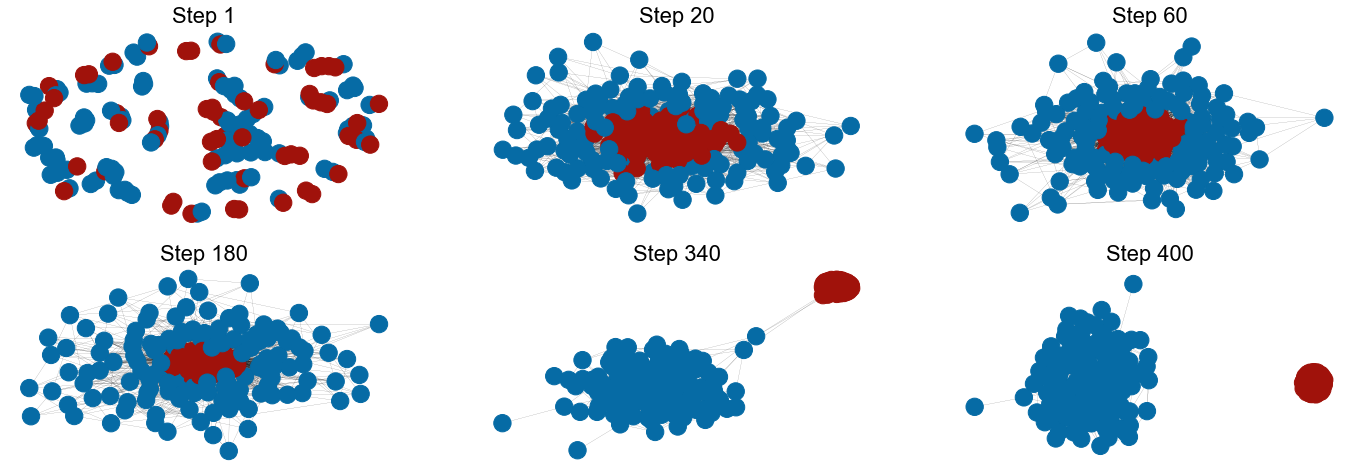

In [6]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent id to a color based on type '''
# 'col1' if MA, 'col2' if NA, 'col3' otherwise (if TA)
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 1)
edge_list_2 = get_edge_list(model, step_num = 20)
edge_list_3 = get_edge_list(model, step_num = 60)
edge_list_4 = get_edge_list(model, step_num = 180)
edge_list_5 = get_edge_list(model, step_num = 340)
edge_list_6 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
G4 = create_graph(edge_list_4, dict_ids_type)
G5 = create_graph(edge_list_5, dict_ids_type)
G6 = create_graph(edge_list_6, dict_ids_type)
    
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 
pos4 = nx.spring_layout(G4) 
pos5 = nx.spring_layout(G5) 
pos6 = nx.spring_layout(G6) 

# plot each Graph
plt.subplot(231)
graph_plot(G1, pos1, title="Step 1",  width = 0.1)
plt.subplot(232)
graph_plot(G2, pos2, title="Step 20", width = 0.1)
plt.subplot(233)
graph_plot(G3, pos3, title="Step 60", width = 0.1)
plt.subplot(234)
graph_plot(G4, pos4, title="Step 180", width = 0.1)
plt.subplot(235)
graph_plot(G5, pos5, title="Step 340", width = 0.1)
plt.subplot(236)
graph_plot(G6, pos6, title="Step 400", width = 0.1)

In [7]:
''' Get the average number of MA encountered by each agent_type '''
agent_df = model.datacollector.get_agent_vars_dataframe()
agent_df['Num_Agents'] = 1
num_agents = agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()["Num_Agents"].tolist()
agent_df.xs(N_steps-1, level="Step").groupby("Type").sum()/[1,num_agents,1]

# we average also Num_Trust_values, which allows to get an idea of how many other agents each
# agent type visited

,Wealth,MA_encoutered,Num_Agents
Type,,,
MA,2595019.0,67.0,68.0
TA,1022008.0,68.0,132.0


**Comment:**


    In our model, isolation is generally achieved between step 180 and 400, depending on how alpha and beta are set. The result however, is identical to that in the paper: TA agents achieve isolation. 
    We notice, though, that this reuslt requires each TA to interact with each MA 

<a id="experiment_2"> </a>
# Replicating Experiment 2

All as before, except for: TA_perc = 55%, MA_perc = 34%, NA_perc = 11%. 

**What will agent society look like after 400 steps? Who will end up earning the most, on average?**


[Back on top](#top)

---
Firstly, we replicate the network plotted in the paper, which is done on just 50 agents

In [9]:
''' MODEL PARAMETERS '''
N = 50       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.55  # % of Trust-Aware we want
MA_perc     = 0.34  # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

# unsilence if homog. omegas
#omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

''' RUN THE MODEL '''
# Model instance
model = GameModel(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  #omega_vals[0], omega_vals[1],
                  DT) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

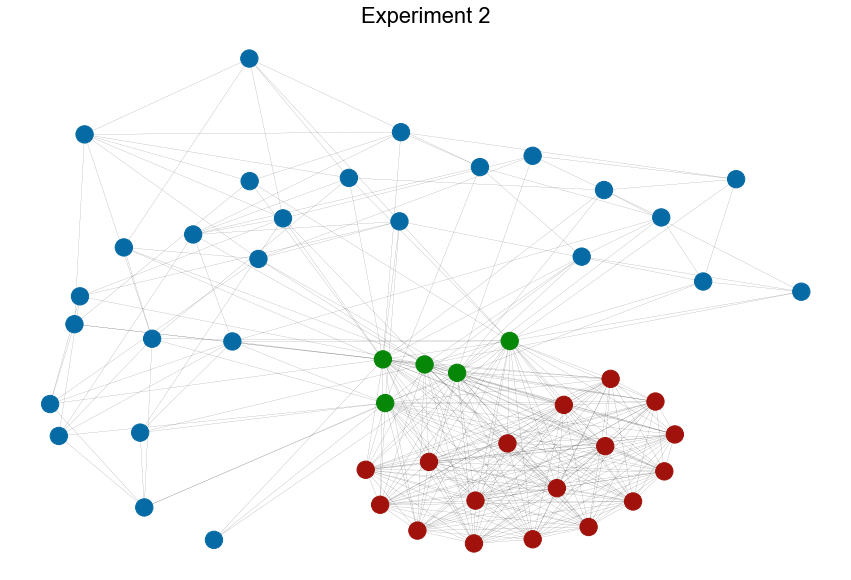

In [10]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating list with all the connections (at last step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list = get_edge_list(model, step_num= N_steps-1)

''' creating graph '''
G = create_graph(edge_list, dict_ids_type)
    
''' plotting graph'''
matplotlib.rcParams['figure.figsize']= [15,10]
pos = nx.kamada_kawai_layout(G)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
graph_plot(G, pos, title="Experiment 2" , width = 0.1)

It appears to be identical to the one showed in the paper

---

Now we run the model with all agents to evaluate results

In [11]:

''' MODEL PARAMETERS '''
N = 200       # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0     # % of Trust-Aware-plus we want
TA_perc     = 0.55  # % of Trust-Aware we want
MA_perc     = 0.34  # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

# unsilence if homog. omegas
#omega_vals = [0.6, -0.6]      # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

''' RUN THE MODEL '''
# Model instance
model = GameModel(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  #omega_vals[0], omega_vals[1],
                  DT) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

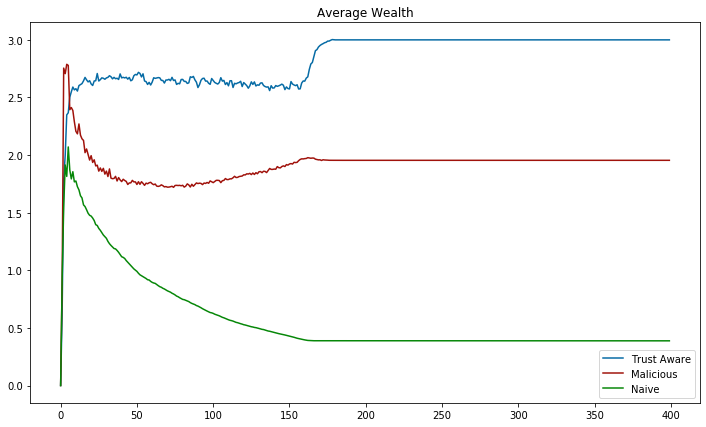

In [12]:
'''Let's look at the wealth distribution '''
model_df = model.datacollector.get_model_vars_dataframe()[["avg_TA_wealth", "avg_MA_wealth", "avg_NA_wealth"]]
model_df.columns=["Trust Aware", "Malicious", "Naive"]
matplotlib.rcParams['figure.figsize']= [12,7]
model_df.plot(color = ['#066BA5','#A0120B','#068708'], title = "Average Wealth")

**Comment:**

    With the introduction of Naive agents, TA are less able to separate themselves from MA. Indeed, some few direct connections remain between the two, and they are indirectly connected by Naive agents, who will never drop  anyone. This will let them be exploited by MA, as we can see by their diminishing average returns, in the green line. TA average increase of utility stabilizes at 3, as they get more and more connected with other TA, which will allow for the cooperation reward of 3. 
    
    Compared to the plot shown in the paper, our model gives about the same results, the differences being that it seems to converge earlier, and MA aren't able to reach the peak at 4, for reasons we will investigate and clarify in the following experiment

<a id="experiment_3"> </a>
# Replicating Experiment 3

All as before, but here we run 5 models, varying the proportion of Naive and Trust-Aware, while Malicious are always 34%:

Population  | Naive | Trust-Aware | Malicious|
:-----:|:--------:|:-----------:|:-----------:
pop1 | 0%  | 66% | 34% |
pop2 | 11% | 55% | 34% |
pop3 | 22% | 44% | 34% |
pop4 | 33% | 33% | 34% |
pop5 | 44% | 22% | 34% |




**How will the average equilibrium earnings increase?**


[Back on top](#top)

In [13]:
''' MODEL PARAMETERS '''
N = 200   # num agents
N_steps = 400 # num steps

''' AGENT PARAMETERS '''
alpha_vals = [0.2, 0.2]       # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.3, -0.3]     # values of beta for DI and WI  (must be < 0)
DT = 0.25                     # threshold relevant for WI decision rule, set to 0.25 in the paper

# unsilence if homog. omegas
#omega_vals = [0.6, -0.6]  # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)

'''CREATING THE 5 POPULATIONS'''
# TAplus, TA, MA, NA
atperc_1 = [0, .66, .34, 0]
atperc_2 = [0, .55, .34, .11]
atperc_3 = [0, .44, .34, .22]
atperc_4 = [0, .33, .34, .33]
atperc_5 = [0, .22, .34, .44]

agent_type_groups = [atperc_1,atperc_2,atperc_3,atperc_4,atperc_5]

''' RUN THE MODELS '''
res = [] # place to store results

# run the different models
for pops in agent_type_groups:

    model = GameModel(N,                                     
                  pops[0], pops[1], pops[2], pops[3],
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  #omega_vals[0], omega_vals[1],
                  DT) 

    for i in range(N_steps):                                
        model.step()
        
# Store results of utility at end run (list of pandas.series)
    res.append(model.datacollector.get_model_vars_dataframe()[["avg_MA_wealth", "avg_TA_wealth","avg_NA_wealth"]].iloc[-1])

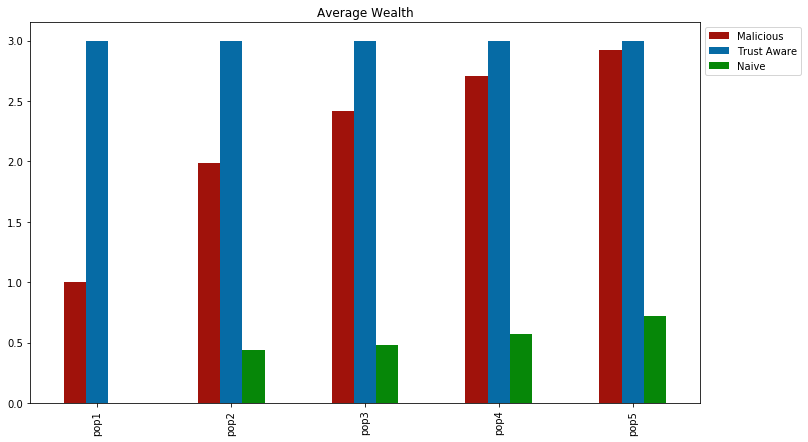

In [14]:
# Barplot of average utility by type, on the different runs


df = pd.DataFrame(res)
df.index = ['pop1','pop2','pop3','pop4','pop5']
df.columns = ['Malicious','Trust Aware', 'Naive']
df.plot(kind='bar', color = ['#A0120B','#066BA5','#068708']*len(df), title = "Average Wealth").legend(bbox_to_anchor=(1, 1))


**Comment:**    
    
    Compared to the paper, we find that in population 5 Malicious still earn, on a normalized average basis, less than TA. We did many tests and checks on this apparently strange behaviour, we kept a simple one in the cell below. In the other cell, we see that this is due to MA having more MA in their neighbourhood than NA, despite there being more NA in the population and connection requests being sent at random. This means that, normalizing by the number of neighbour, MA earn slightly less than what they would if they had more NA to exploit. We give an insight on this in the report, here we briefly mention one of the causes.
    
    When only MA will be sending requests (i.e. TA and NA have filled their neighbourhood) the raw probability of their request being sent to an NA  is higher then sending it to an MA. However, since only MAs are sending requests, they themselves will receive only requests from other MAs; adding them to their neighbourhood, thus skeweng their neighbours towards more MA

In [15]:
''' check that we have the right percentages of agents '''
list_of_lists = get_all_agent_types_ids(model, ["TA","MA", "NA"])
TA_ids, MA_ids, NA_ids = list_of_lists[0], list_of_lists[1], list_of_lists[2]

tot = len(TA_ids) + len(MA_ids) + len(NA_ids)

print("Total agents:", tot, "percentages TA:",len(TA_ids)/tot, " percentages NA:",len(NA_ids)/tot, " percentages MA:",len(MA_ids)/tot)
print("\nTot NA:",len(NA_ids), "Tot MA:",len(MA_ids))

Total agents: 200 percentages TA: 0.22  percentages NA: 0.44  percentages MA: 0.34

Tot NA: 88 Tot MA: 68


In [16]:
''' check neighbourhood composition '''
NA_wins = MA_wins = 0
for a in model.schedule.agents:
    if a.unique_id in MA_ids:
        NA_neigh = [a for a in a.neigh_evo[N_steps-1] if a in NA_ids]
        MA_neigh = [a for a in a.neigh_evo[N_steps-1] if a in MA_ids]
        print("MA ", a.unique_id, " : alrd visited ", len(a.visited), '| Neighs : ',len(NA_neigh), len(MA_neigh))
        
        if len(NA_neigh)>0 and len(MA_neigh)>0:
            if len(NA_neigh) > len(MA_neigh):
                NA_wins +=1
            else:
                MA_wins +=1
                
print("\nin only {} on {} cases MA have more NA than MA in their neighbourhood \n".format(NA_wins, NA_wins+MA_wins))

MA  44  : alrd visited  129 | Neighs :  47 54
MA  45  : alrd visited  123 | Neighs :  49 53
MA  46  : alrd visited  116 | Neighs :  50 52
MA  47  : alrd visited  131 | Neighs :  51 50
MA  48  : alrd visited  121 | Neighs :  49 51
MA  49  : alrd visited  129 | Neighs :  46 55
MA  50  : alrd visited  129 | Neighs :  48 52
MA  51  : alrd visited  126 | Neighs :  48 52
MA  52  : alrd visited  125 | Neighs :  47 56
MA  53  : alrd visited  127 | Neighs :  44 56
MA  54  : alrd visited  123 | Neighs :  48 52
MA  55  : alrd visited  122 | Neighs :  47 53
MA  56  : alrd visited  128 | Neighs :  51 50
MA  57  : alrd visited  132 | Neighs :  47 54
MA  58  : alrd visited  125 | Neighs :  48 52
MA  59  : alrd visited  125 | Neighs :  52 48
MA  60  : alrd visited  119 | Neighs :  50 54
MA  61  : alrd visited  126 | Neighs :  43 57
MA  62  : alrd visited  125 | Neighs :  49 51
MA  63  : alrd visited  126 | Neighs :  47 53
MA  64  : alrd visited  125 | Neighs :  49 52
MA  65  : alrd visited  129 | Neig

<a id="experiment_4"> </a>
# Replicating Experiment 4

Same as before, except that now we have TA+ instead of TA, and the following population percentages -> TA+ = 55%, NA = 11%, MA = 34%

**Will TAplus be able to isolate themselves from NA?**


[Back on top](#top)

In [17]:
''' MODEL PARAMETERS '''
N = 200   # num agents
N_steps = 400 # num steps

# agent type distribution
TAplus_perc = 0.55     # % of Trust-Aware-plus we want
TA_perc     = 0        # % of Trust-Aware we want
MA_perc     = 0.34     # % of Malicious we want
NA_perc     = 1 - MA_perc - TA_perc - TAplus_perc    # % of Naive we want

''' AGENT PARAMETERS '''
alpha_vals = [0.05, 0.05]      # values of alpha for DI and WI (must be > 0)
beta_vals  = [-0.1, -0.1]      # values of beta for DI and WI  (must be < 0)
DT = 0.25                      # threshold relevant for WI decision rule, set to 0.25 in the paper

# unsilence if homog. omegas
#omega_vals = [0.6, -0.6]       # values of omega (upper threshold; between -1 and 1) and OMEGA (between -1 and 1; if DI trust > omega, agent is considered trustworthy)


''' RUN THE MODEL '''
model = GameModel(N,                                     # <--- intitialize the model
                  TAplus_perc, TA_perc, MA_perc, NA_perc,
                  alpha_vals[0], alpha_vals[1],
                  beta_vals[0], beta_vals[1],
                  #omega_vals[0], omega_vals[1],
                  DT) 

for i in range(N_steps):                                 # <--- Run the model for N_steps steps
    model.step()

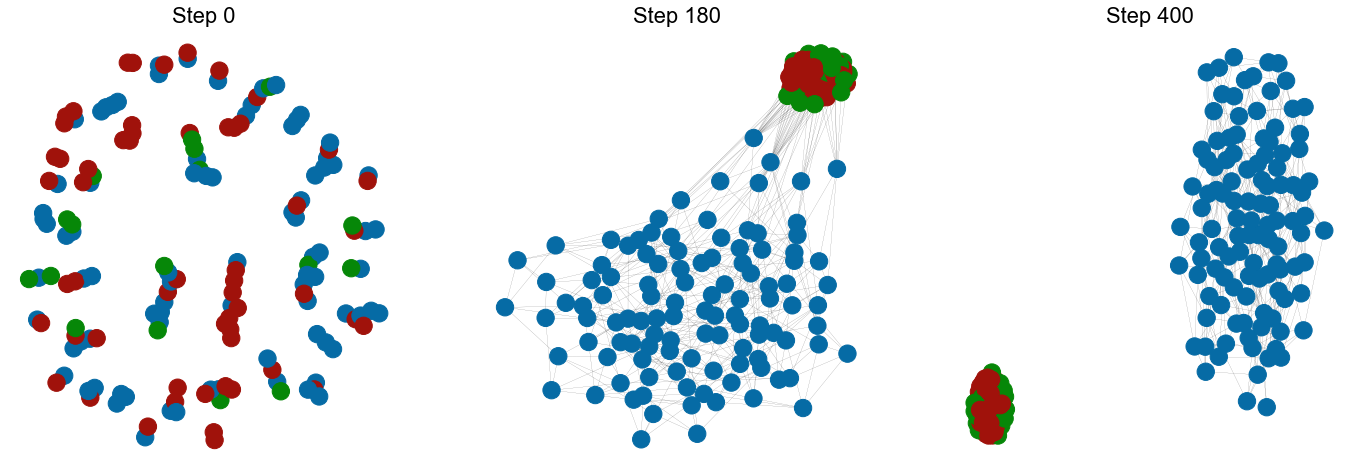

In [18]:
# create the df with all the collected agent-level variables
agent_df = model.datacollector.get_agent_vars_dataframe().xs(0, level='Step')['Type']

''' associate each agent_type to a color '''
dict_ids_type = {agent_df.index[i]:('#A0120B' if agent_df[i]=="MA" else '#068708' if agent_df[i]=="NA" else '#066BA5') for i in range(len(agent_df))}

''' creating lists with all the connections (at given step): [ [(nodei,nodej),(nodei,nodeh)...], [(nodej,nodeh)...] ]'''
edge_list_1 = get_edge_list(model, step_num = 1)
edge_list_2 = get_edge_list(model, step_num = 180)
edge_list_3 = get_edge_list(model, step_num = N_steps-1)

''' creating graphs '''
G1 = create_graph(edge_list_1, dict_ids_type)
G2 = create_graph(edge_list_2, dict_ids_type)
G3 = create_graph(edge_list_3, dict_ids_type)
   
''' plotting graphs '''
matplotlib.rcParams['figure.figsize']= [24, 8]

# create the pos relative to each Graph
pos1 = nx.spring_layout(G1)  # fruchterman_reingold_layout, kamada_kawai_layout, spring_layout
pos2 = nx.spring_layout(G2) 
pos3 = nx.spring_layout(G3) 

# plot each Graph
plt.subplot(131)
graph_plot(G1, pos1, title="Step 0",  width = 0.1)
plt.subplot(132)
graph_plot(G2, pos2, title="Step 180", width = 0.1)
plt.subplot(133)
graph_plot(G3, pos3, title="Step 400", width = 0.1)

**Comment:**

    TAplus, dropping also unreliable agents in terms of WI, manage to identify Naive agents as well as Malicious ones, ending up forming a cluster among themselves only.
    
    As in other experiments, our model converges faster. We can have some connecions remain at step 180 by setting beta low enough, thus agents with an high OMEGA will reamin connected longer. Though it isn't a meaningful improvement, so we will choose alpha and beta on another basis, and we will run sensitivity for it later
  